In [2]:
%config Completer.use_jedi = False # tab 키 안먹을때

# Named Entity Recognition (NER) with BiLSTM 
- 양방향 LSTM을 이용하여 개체명 인식기 생성하기(https://wikidocs.net/147219)
- dataset(https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
data = pd.read_csv('./data/ner_dataset.csv', encoding='latin1')
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
print('dataframe len :', len(data))
print('null data :', data.isnull().sum())

dataframe len : 1048575
null data : Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [6]:
# sentence 열 중복 제거
print('unique sentence:',data['Sentence #'].nunique())
print('unique word:',data['Word'].nunique())
print('unique tag:',data['Tag'].nunique())

# --> 47,959개의 문장, 35,178개의 단어, 17개 종류의 NER Tags

unique sentence: 47959
unique word: 35178
unique tag: 17


In [7]:
print('Tag 값 개수 카운트')
print('-' * 20)
print(data['Tag'].value_counts())

Tag 값 개수 카운트
--------------------
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


In [8]:
data = data.fillna(method='ffill') 
# 'ffill' : Null값을 가진 행 바로 앞 행의 값으로 Null값을 채움
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [9]:
# 모든 문장 소문자로
data['Word'] = data['Word'].str.lower()
print('Word 열 중복 제거 값 개수 :', data.Word.nunique())

Word 열 중복 제거 값 개수 : 31817


In [10]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [11]:
# paring word with tag information
func = lambda x : [(w, t) for w, t in zip(x['Word'].values.tolist(), x['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]
print(f'전체 샘플 개수 : {len(tagged_sentences)}')

전체 샘플 개수 : 47959


In [12]:
print(tagged_sentences[0]) # sample print

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [13]:
# 훈련을 위해 훈련 데이터의 단어와 태깅 정보를 분리
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences : # 문장 47,959개 샘플을 1씩 불러옴
    
    # 각 샘플 단어는 sentence에, 태깅 정보는 tag_info에 저장
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence)) # 각 샘플에서 단어정보만 저장
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장
    
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.86


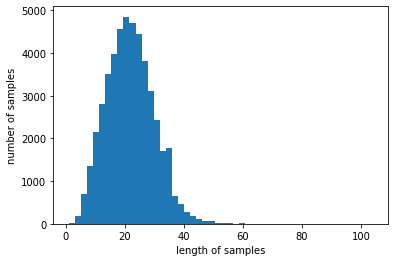

In [14]:
# 전체 데이터 길이 분포 확인

print(f'샘플의 최대 길이 : {max(len(l) for l in sentences)}')
print(f'샘플의 평균 길이 : {sum(map(len, sentences)) / len(sentences):.2f}')
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# keras tokenizer로 encoding
src_tokenizer = Tokenizer(oov_token = 'OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 체 저장
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [16]:
vocab_size = len(src_tokenizer.word_index) + 1 # 문장
tag_size = len(tar_tokenizer.word_index) + 1 # 개체명

print('단어 집합의 크기 :', vocab_size)
print('개체명 태깅 정보 집합의 크기 :', tag_size)

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [17]:
print('단어 OOV의 인덱스 :', src_tokenizer.word_index['OOV'])

단어 OOV의 인덱스 : 1


In [18]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [19]:
word_to_index = src_tokenizer.word_index 
index_to_word = src_tokenizer.index_word # 인덱스로부터 단얼를 리턴
ner_to_index = tar_tokenizer.word_index # 인덱스로부터 태깅 정보 리턴
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [20]:
decoded =[]
for index in X_data[0] :
    decoded.append(index_to_word[index])
    
print('기존 문장 :', sentences[0])
print('디코딩 문장:', decoded)

기존 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장: ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [21]:
# 데이터 분포 40~60 이므로 70으로 max len 설장
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [22]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [23]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True)) # mask_zero = True // 숫자 0은 연산에서 제외
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.1)
# notimplemented numpy error (symbolic tensor) ==> pip install numpy==1.19.5

Epoch 1/6


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node gradient_tape/sequential/embedding/embedding_lookup/Reshape/_66}}]] [Op:__inference_train_function_14575]

Function call stack:
train_function


In [ ]:
i = 6
y_predicted = model.predict(np.array([X_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)
labels = np.argmax(y_test[i], -1)

print('{:15}|{:5}|{}'.format('단어','실제값','예측값'))
print(35 * '=')

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]) :
    if word != 0 : # PAD 값 제외
        print(f'{index_to_word[word]:17}: {index_to_ner[tag]:7} {index_to_ner[pred]}')


## metrics - F1 score

In [ ]:
# !pip install seqeval

### Seqeval
- seqeval is a Python framework for sequence labeling evaluation. seqeval can evaluate the performance of chunking tasks such as named-entity recognition, part-of-speech tagging, semantic role labeling and so on. 
- This is well-tested by using the Perl script conlleval, which can be used for measuring the performance of a system that has processed the CoNLL-2000 shared task data. seqeval supports following formats: IOB1 IOB2 IOE1 IOE2 IOBES See the [README.md] file at https://github.com/chakki-works/seqeval for more information.

In [ ]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O',
          'B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O',
          'O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels) 
print('예측값 :',predicted)

In [ ]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

In [ ]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O',
          'O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC',
          'O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O',
             'O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O',
             'O','O','O','O','O','O','O','O','O','O']

print(classification_report([labels], [predicted]))

In [ ]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences) :
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다
    for sequence in sequences :
        word_sequence = []
        # 시퀀스로부터 확률벡터 또는 원핫벡터를 하나씩 꺼낸다
        for pred in sequence :
            # 정수로 변환 (예) pred가 [0, 0, 1, 0, 0] 라면 1의 인덱스인 2를 맅천
            pred_index = np.argmax(pred)
            # index_to_ner 를 사용하여 정수를 태깅정보로 변환. PAD는 O로 변경
            word_sequence.append(index_to_ner[pred_index].replace('PAD', 'O'))
        result.append(word_sequence)
    return result

y_pred = model.predict([X_test])
pred_tags = sequences_to_tag(y_pred)
test_tags = sequences_to_tag(y_test)

print(f'F1 score : {f1_score(test_tags,pred_tags):.3f}')

---

## BiLSTM-CRF 이용한 개체명 인식
- 기존 bi-LSTM 모델에 CRF(conditional random field) 층을 추가하여 보다 모델을 개선시킨 양방향
LSTM + CRF 모델을 사용하여 개체명 인식 수행
- 논문 참조(https://arxiv.org/pdf/1508.01991v1.pdf)

## CRF(Conditional Random Field)
- CRF 는 Conditional Random Field의 약자로, 이전에 독자적으로 존재해왔던 모델임.
이를 양방향 LSTM 모델 위에 하나의 층으로 추가하여, 양방향 LSTM + CRF 모델이 탄생함.
- CRF층을 LSTM 위에 추가하면, 모델은 예측 개체명/레이블 사이의 의존성을 고려할 수 잇음

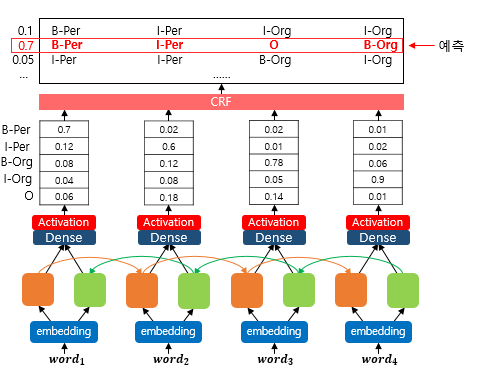

- 기존에 CRF층이 존재하지 않았던 양방향 LSTM 모델은 활성화 함수를 지난 시점에서 개체명을 결정
- --> CRF층을 추가한 모델에서는 활성화 함수의 결과들이 CRF층의 입력으로 전달됨
- CRF층은 이러한 구조에서 점차 훈련 데이터로부터 제약사항을 학습하게 됨
> 1. 문장 첫번째 단어에서는 I가 나오지 않는다
> 2. O-I 패턴은 나오지 않는다
> 3. B-I-I 패턴에서 개체명은 일관성을 유지한다 (예를 들어 B-Per 다음에 I-Org는 나오지 않는다)

- 즉 양방향 LSTM은 `입력 단어`에 대한 양방향 문맥을 반영하며, CRF는 `출력 레이블`에 대한 양방향 문맥을 반영

In [ ]:
# !pip install keras-crf

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

embedding_dim = 128
hidden_units = 128
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len), dtype=tf.int32, name='sequence_input')

model_embedding= Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./bilstm_crf_cp.ckpt', monitor='val_decode_seqeunce_accuracy',
                    mode='max',verbose=1,save_best_only=True,save_weights_only=True)
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15,
                   validation_split=0.1, callbacks=[mc, es])

In [ ]:
# model.load_weights('./bilstm_crf_cp.ckpt')

In [ ]:
i = 13
y_pred = model.predict(np.array([X_test[i]]))[0] # 입력 테스트 샘플에 대해 pred y 리턴
labels = np.argmax(y_test[i], -1)

print('{:15}|{:5}|{}'.format('단어','실제값','예측값'))
print('=' * 35)

for word, tag, pred in zip(X_test[i], labels, y_pred[0]) :
    if word != 0 :
        print(f'{index_to_word[word]:17}: {index_to_ner[tag]:7} {index_to_ner[pred]}')

In [ ]:
y_pred = model.predict(X_test)[0]
y_pred[:2]

In [ ]:
# 정수 시퀀스를 입력받아 태깅정보 시퀀스를 리턴하는 함수 sequences_to_tag_for_crf 생성
def sequences_to_tag_for_crf(sequences) :
    result = []
    # 시퀀스를 전체에서 하나씩 꺼냄
    for sequence in sequences :
        word_sequence = []
        # 시퀀스에서 예측 정수 레이블을 하나씩 꺼냄
        for pred_idx in sequence :
            # index_to_ner를 사용하여 정수를 태깅 정보로 변환 'PAD'는 'O'로 변경
            word_sequence.append(index_to_ner[pred_idx].replace('PAD', 'O'))
        result.append(word_sequence)
        
    return result

pred_tags = sequences_to_tag_for_crf(y_pred)
test_tags = sequences_to_tag(y_test)

print('F1-score :', f1_score(test_tags, pred_tags))
print(classification_report(test_tags, pred_tags))